In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [6]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [8]:
wiki.invoke("Sachin Tendulkar")

'Page: Sachin Tendulkar\nSummary: Sachin Ramesh Tendulkar ( ; Marathi: [sətɕin t̪eɳɖulkəɾ]; born 24 April 1973) is an Indian former international cricketer who captained the Indian national team. He is widely regarded as one of the greatest cricketers of all time, and is the holder of several world records, including being the all-time highest run-scorer in both ODI and Test cricket, receiving the most player of the match awards in international cricket, and being the only batsman to score 100 int'

In [9]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

C:\Users\prana\AppData\Local\Temp\ipykernel_31664\1535493036.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [11]:
tavily.invoke("Provide me the recent AI News")

[{'title': 'Latest AI Breakthroughs and News: May, June, July 2025',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': "Summary: OpenAI and SoftBank are planning to build a small data center by the end of 2025 to support the Stargate AI initiative . The project aims to explore more energy-efficient AI infrastructure at localized scales. Sources suggest this could serve as a pilot for SoftBank's larger $1 trillion “Crystal Land” AI hub.",
  'score': 0.67347145},
 {'title': 'AI News & Artificial Intelligence | TechCrunch',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': 'Digital generated image of abstract AI data chat icons flying over digital surface with codes\n\n### Gupshup raises $60M in equity and debt, leaves unicorn status hanging\n\n### Amazon acquires Bee, the AI wearable that records everything you say\n\nLarry Ellison, chairman of Oracle Corp.\n\n### OpenAI agreed to pay Oracle $30B a year for data center servi

In [12]:
tools = [arxiv, wiki, tavily]

In [19]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")

In [20]:
llm.invoke("What is AI")

AIMessage(content='<think>\nOkay, the user is asking what AI is. Let me start by defining it in a simple way. AI stands for Artificial Intelligence, which is the simulation of human intelligence in machines. I should mention the key areas like learning, reasoning, problem-solving, perception, and language understanding.\n\nI need to explain that AI can be narrow or general. Most current AI is narrow, focused on specific tasks like image recognition or language translation. General AI, which can handle any intellectual task a human can, doesn\'t exist yet. Maybe give examples of existing AI applications, such as virtual assistants, recommendation systems, or self-driving cars.\n\nAlso, it\'s important to note the different techniques used in AI, like machine learning and deep learning. Maybe explain that machine learning involves algorithms improving at tasks with experience, and deep learning uses neural networks inspired by the human brain.\n\nI should mention the history a bit, like 

In [21]:
llm_with_tools = llm.bind_tools(tools=tools)

In [22]:
llm_with_tools.invoke("What is the recent news on AI")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. Let me see which tool I should use here. The available tools are arxiv, wikipedia, and tavily_search_results_json.\n\nArxiv is for academic papers, so maybe not the best choice for news. Wikipedia might have general information but not the latest news. Tavily_search_results_json sounds like a search engine that can fetch recent news articles. That\'s probably the right tool here. I\'ll use tavily_search_results_json with the query "recent news on AI" to get the latest updates.\n', 'tool_calls': [{'id': '5vhbker4h', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 145, 'prompt_tokens': 267, 'total_tokens': 412, 'completion_time': 0.275583815, 'prompt_time': 0.010841926, 'queue_time': 0.055489834, 'total_time': 0.286425741}, 'model_name': 'qwen/qwen3-32

In [23]:
from typing import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [24]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [30]:
def tool_calling_llm(state: State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", END)

In [31]:
graph = builder.compile()

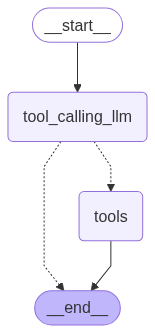

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages = graph.invoke({"messages": "1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (6nx2r4wvj)
 Call ID: 6nx2r4wvj
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [34]:
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

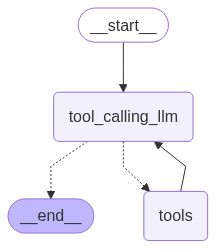

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [37]:
messages = graph.invoke({"messages": "Hi my name is Pranav and please tell me the the recent research papers on quantum computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is Pranav and please tell me the the recent research papers on quantum computing
================================== Ai Message ==================================
Tool Calls:
  arxiv (kfv732qcj)
 Call ID: kfv732qcj
  Args:
    query: quantum computing AND submittedDate:[2023-01-01 TO 2024-01-01]
================================= Tool Message =================================
Name: arxiv

Published: 2023-02-24
Title: A Uniform Quantum Computing Model Based on Virtual Quantum Processors
Authors: George Gesek
Summary: Quantum Computers, one fully realized, can represent an exponential boost in
computing power. However, the computational power of the current quantum
computers, referred to as Noisy Internediate Scale Quantum, or NISQ, is
severely limited because of environmental and intrinsic noise, as well as the
very low connectivity between qubits compared to their total amount. W
================